# Clustering Gerarchico

Importate queste librerie

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import math
import sys
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

## Preparazione dataset

In [32]:
df = pd.read_csv(r"./data/training_ready_no_regression.csv")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.copy(deep=True).select_dtypes(include=numerics)
del df_num['RefId']
del df_num['VehicleAge']
del df_num['IsOnlineSale']
df_num.head()

,IsBadBuy,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
0,1,61184,6796.0,7555.0,10140.0,10805.0,6628.0,7535.0,9605.0,10650.0,6100.0,533
1,0,92383,5480.0,6461.0,6418.0,7478.0,5480.0,6461.0,6418.0,7478.0,4000.0,1630
2,0,45965,8067.0,8580.0,11073.0,11652.0,7497.0,8102.0,10721.0,11350.0,7500.0,693
3,0,80169,4817.0,6658.0,5702.0,7691.0,4817.0,6658.0,5702.0,7691.0,4725.0,1633
4,0,77372,5430.0,6633.0,6364.0,7664.0,5370.0,6811.0,6300.0,7856.0,5670.0,1623


In [33]:
# Rimossi perchè ridondanti con VehBCost

del df_num['MMRAcquisitionAuctionCleanPrice']
del df_num['MMRAcquisitionRetailAveragePrice']
del df_num['MMRAcquisitonRetailCleanPrice']
del df_num['MMRCurrentAuctionAveragePrice']
del df_num['MMRCurrentAuctionCleanPrice']
del df_num['MMRCurrentRetailAveragePrice']
del df_num['MMRCurrentRetailCleanPrice']
del df_num['MMRAcquisitionAuctionAveragePrice']

# Rimuovo informazione sulla classificazione

classes = df_num['IsBadBuy']
del df_num['IsBadBuy']

### Eliminazione Outliers

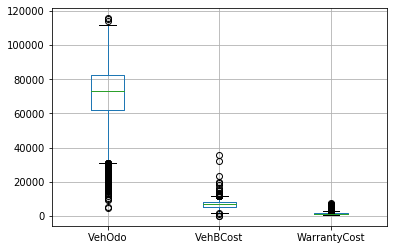

In [34]:
df_num.boxplot()

In [35]:
tot = df_num.shape[0]
# identify outliers with interquartile range
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
k = 1.35
df_num = df_num[~((df_num < (Q1 - (k * IQR))) | (df_num > (Q3 + (k * IQR)))).any(axis=1)]
tot_no_outlier = df_num.shape[0]

print('Outlier removed: '+str(tot-tot_no_outlier))

Outlier removed: 1568


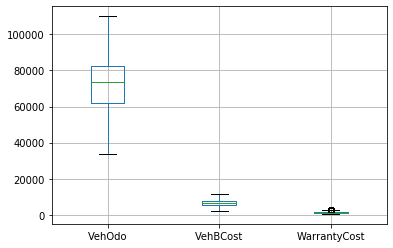

In [36]:
df_num.boxplot()

In [37]:
df_sampled = df_num.copy(deep=True).sample(n=20000, random_state=1)

### Normalizzazione

In [38]:
scaler = MinMaxScaler()
X=scaler.fit_transform(df_sampled.values)
i=0

df_num_visual = df_sampled.copy(deep=True) # usiamo questa copia per visualizzare i clusters 

for col in df_num.columns:
    df_num_visual[col] = X[:,i]
    i+=1
X = df_num_visual
df_num_visual.head()

,VehOdo,VehBCost,WarrantyCost
5473,0.760676,0.443031,0.802193
51479,0.623462,0.387168,0.416172
13192,0.332124,0.661504,0.247145
35520,0.580901,0.868363,0.423481
10216,0.562322,0.342920,0.263134


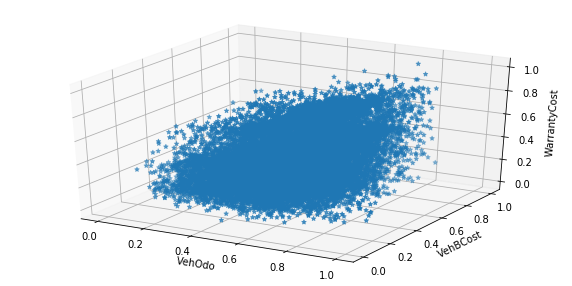

In [39]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')

x =df_num_visual['VehOdo']
y =df_num_visual['VehBCost']
z =df_num_visual['WarrantyCost']

ax.scatter(x, y, z, marker='*')

ax.set_xlabel('VehOdo')
ax.set_ylabel('VehBCost')
ax.set_zlabel('WarrantyCost')

plt.show()

## Hierarchical Clustering

In [40]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

Scelgo alcune metriche e metodi per il clustering da testare.

In [41]:
metrics=['cosine', 'euclidean']
methods=['complete', 'single', 'ward', 'average']

Dato che "Ward can only work with euclidean distances", rimuovo il modello ward_cosine

In [42]:
data_dist = {}
data_link = {}

for m in metrics:
    data_dist[m] = pdist(X, metric = m)
    for met in methods:
        if met=='ward' and m=='cosine':
            continue
        data_link[met+'_'+m] = linkage(data_dist[m], method=met)

Visualizzo i dendogrammi per ogni possibile coppia (metrica, metodo di clusetring).

Dendogramma ottenuto con: complete_cosine


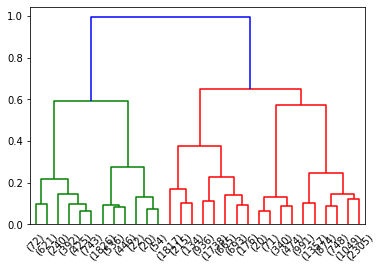

Dendogramma ottenuto con: single_cosine


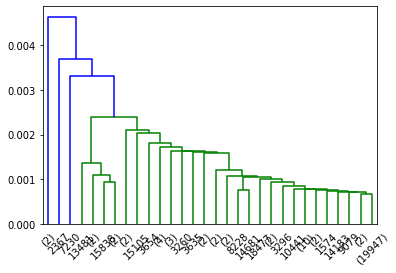

Dendogramma ottenuto con: average_cosine


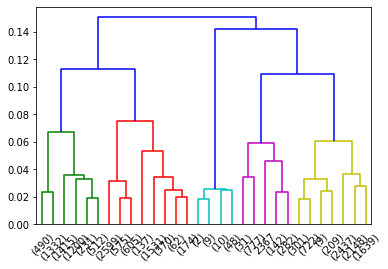

Dendogramma ottenuto con: complete_euclidean


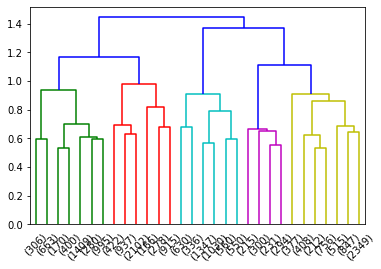

Dendogramma ottenuto con: single_euclidean


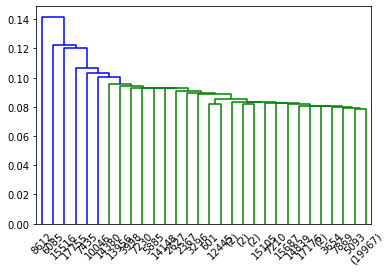

Dendogramma ottenuto con: ward_euclidean


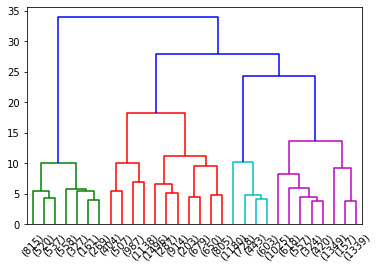

Dendogramma ottenuto con: average_euclidean


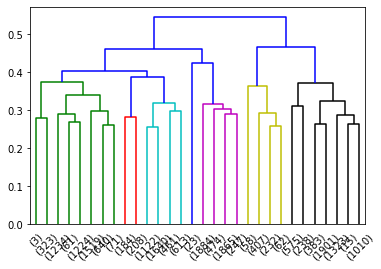

In [43]:
for key, values in data_link.items():
    print('Dendogramma ottenuto con: '+key)
    dendrogram(data_link[key], truncate_mode='lastp')
    plt.savefig('./plots/Hierarchical/dendrogram_'+key+'.png')
    plt.show()

Dai dendogrammi sopra, stimiamo il numero di cluster per ogni coppia metrica-metodo

In [44]:
n_clusters=[2, 2, 2, 3, 2, 2, 3]

Ora creiamo i modelli e li fittiamo con i dati e per ognuno stampiamo il suo scatter e silhouette

In [45]:
models={}
i=0
for m in metrics:
    for met in methods:
        if met=='ward' and m=='cosine':
            continue
        models[met+'_'+m] = AgglomerativeClustering(distance_threshold=None, n_clusters=n_clusters[i], affinity=m, linkage=met)
        i+=1

In [46]:
for key, model in models.items():
    models[key]= model.fit(X)

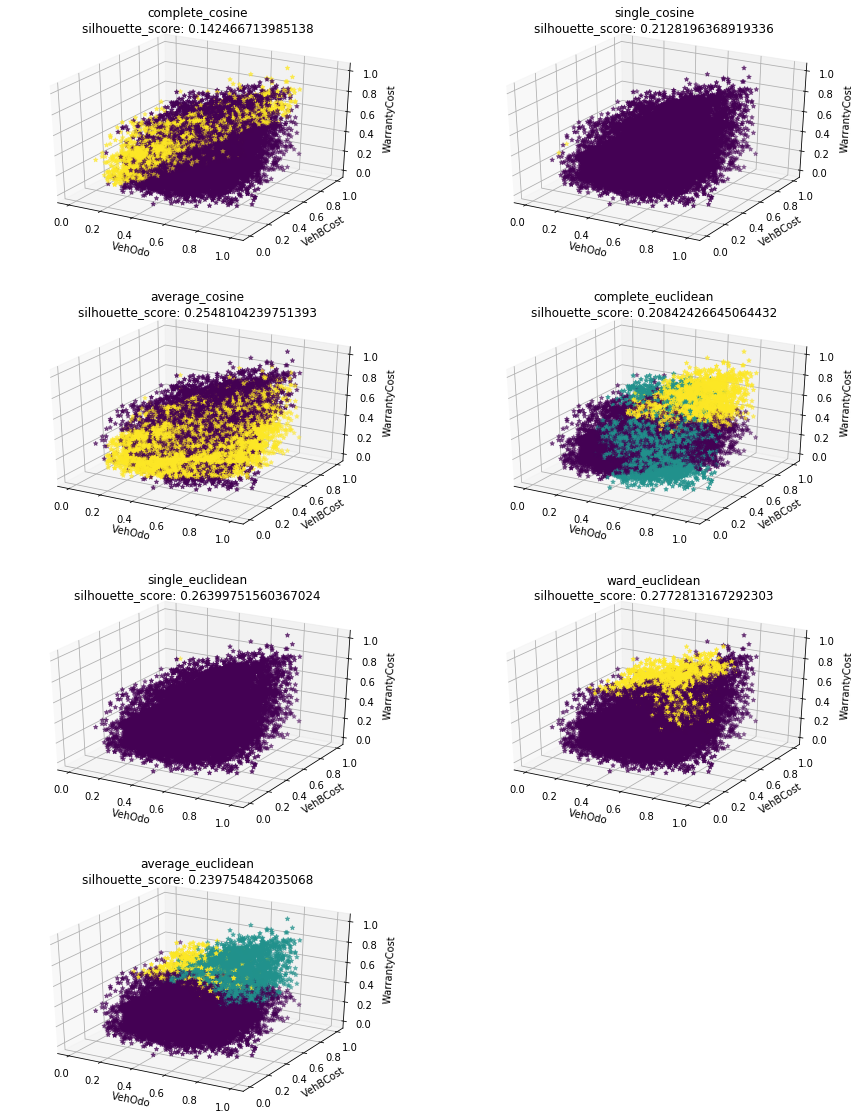

In [47]:
fig = plt.figure(figsize=(15, 20))
index=1
for key, model in models.items():
    ax = fig.add_subplot(4, 2, index, projection='3d')
    x =df_num_visual['VehOdo']
    y =df_num_visual['VehBCost']
    z =df_num_visual['WarrantyCost']
    ax.scatter(x, y, z, marker='*', c=model.labels_)
    score = silhouette_score(df_num_visual, model.labels_)
    ax.set_title(key+'\n'+'silhouette_score: '+str(score))
    ax.set_xlabel('VehOdo')
    ax.set_ylabel('VehBCost')
    ax.set_zlabel('WarrantyCost')
    
    index+=1

In [48]:
import itertools

def scatter_plot_2D(labels, attributes, affinity, linkage, thrash):
    for p in itertools.combinations(attributes, 2):
        plt.scatter(df_num_visual[p[0]], df_num_visual[p[1]],
            c=labels, s=20)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.savefig('./plots/Hierarchica/scatter_'+str(thrash)+'_'+affinity+'_'+linkage+'_'+p[0]+'_'+p[1]+'.png')
        plt.show()

attributes = ['VehOdo', 'VehBCost', 'WarrantyCost']

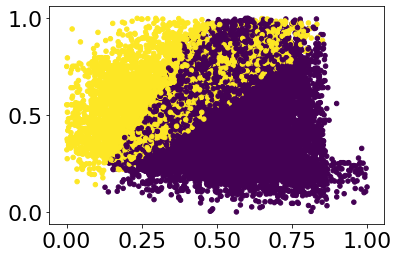

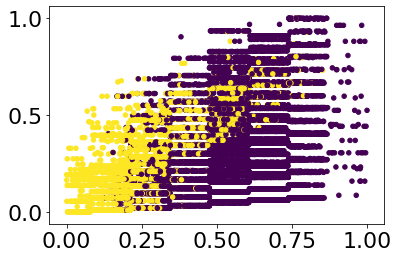

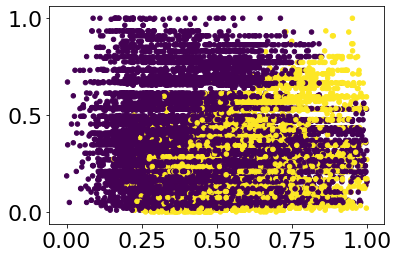

In [49]:
model = AgglomerativeClustering(distance_threshold=0.7, n_clusters=None, affinity='cosine', linkage='complete')
model = model.fit(X)

scatter_plot_2D(model.labels_, attributes, 'cosine', 'linkage', 0.7)

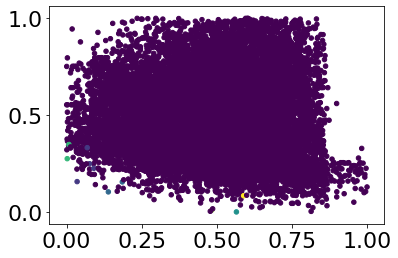

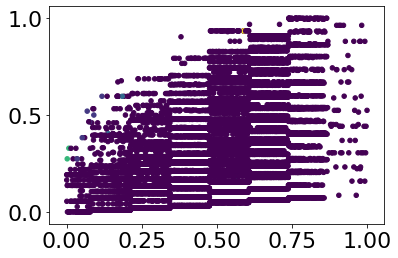

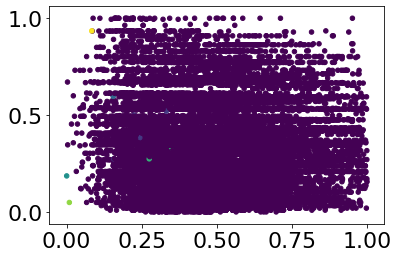

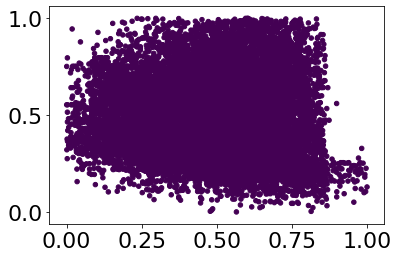

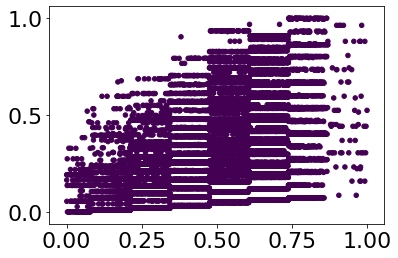

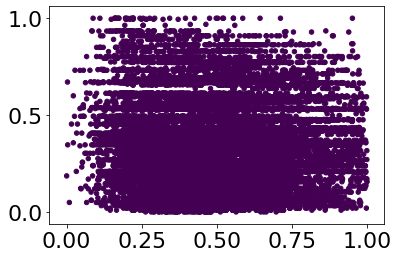

In [50]:
distances = [0.002, 0.035]
models = []
for d in distances:
    models.append(AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity='cosine', linkage='single'))

for m in models:
    m = m.fit(X)
    scatter_plot_2D(m.labels_, attributes, 'cosine', 'single', m.distance_threshold)

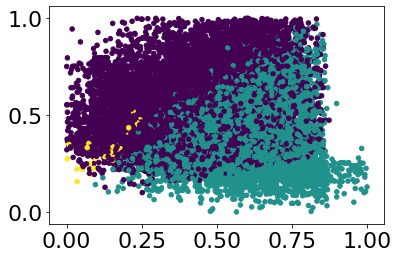

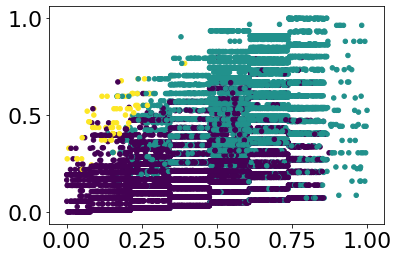

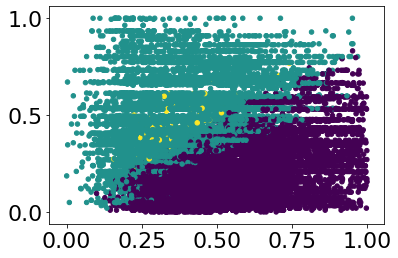

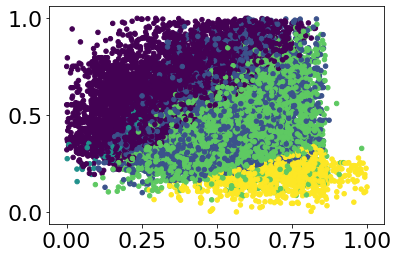

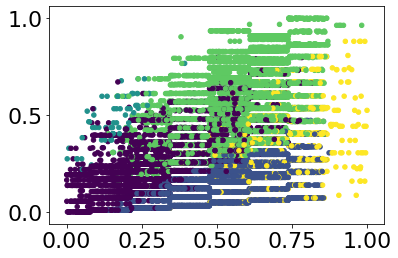

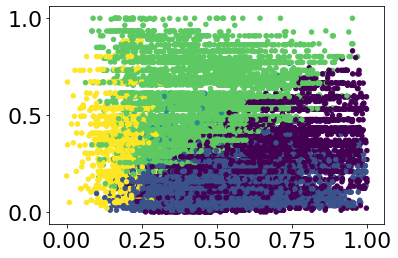

In [51]:
distances = [0.125, 0.08]
models = []
for d in distances:
    models.append(AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity='cosine', linkage='average'))

for m in models:
    m = m.fit(X)
    scatter_plot_2D(m.labels_, attributes, 'cosine', 'average', m.distance_threshold)

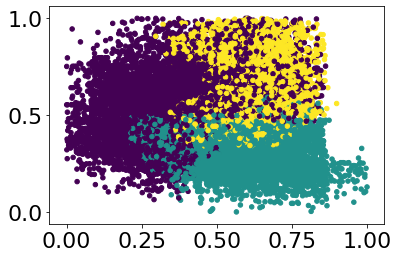

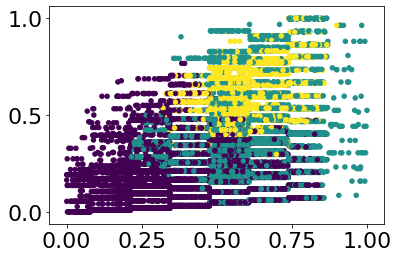

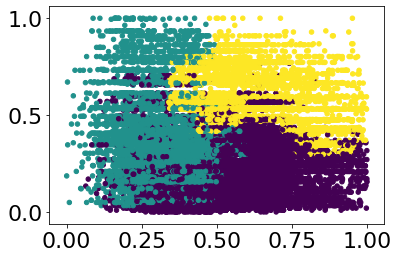

In [52]:
model = AgglomerativeClustering(distance_threshold=1.2, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(X)

scatter_plot_2D(model.labels_, attributes, 'euclidean', 'complete', 1.2)

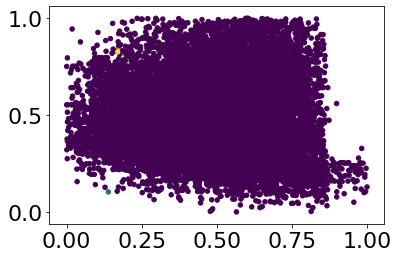

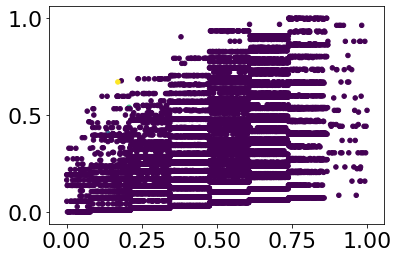

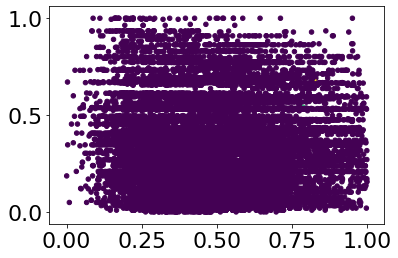

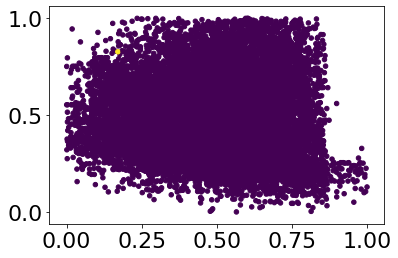

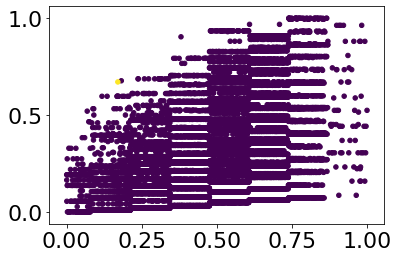

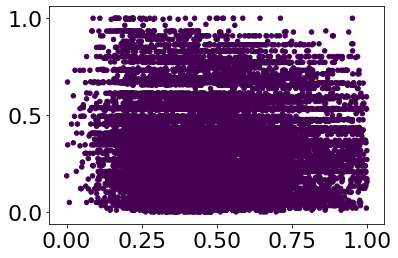

In [53]:
distances = [0.12, 0.14]
models = []
for d in distances:
    models.append(AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity='euclidean', linkage='single'))

for m in models:
    m = m.fit(X)
    scatter_plot_2D(m.labels_, attributes, 'euclidean', 'single', m.distance_threshold)

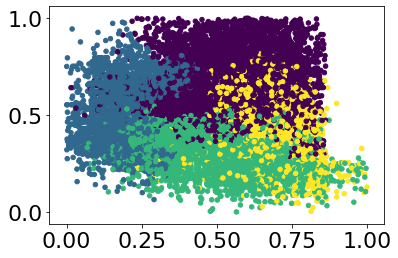

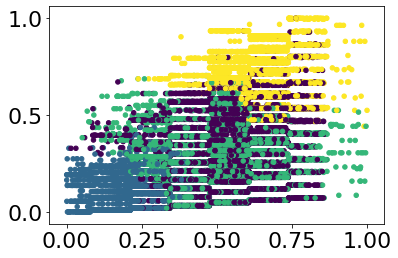

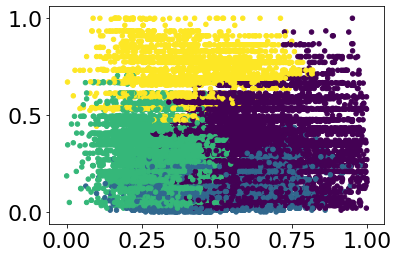

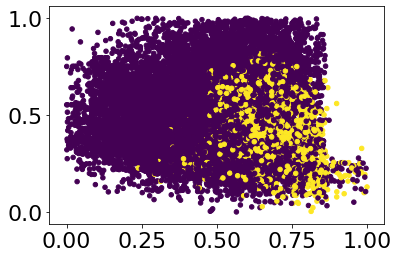

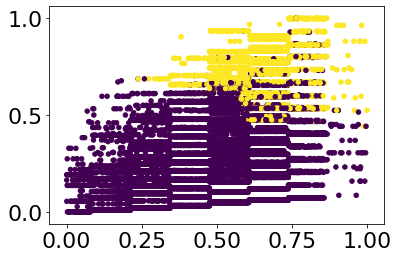

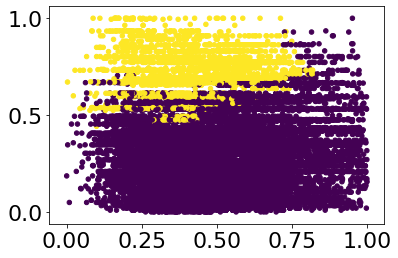

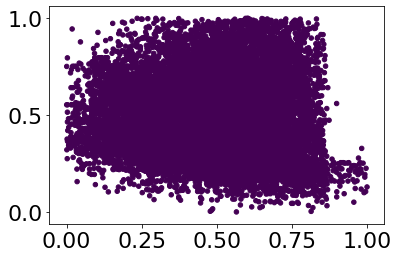

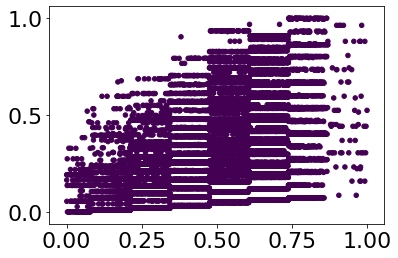

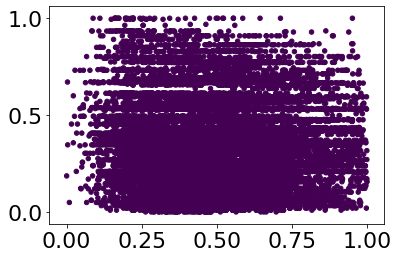

In [54]:
distances = [20, 30, 35]
models = []
for d in distances:
    models.append(AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity='euclidean', linkage='ward'))

for m in models:
    m = m.fit(X)
    scatter_plot_2D(m.labels_, attributes, 'euclidean', 'ward', m.distance_threshold)

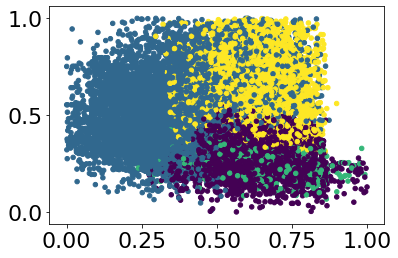

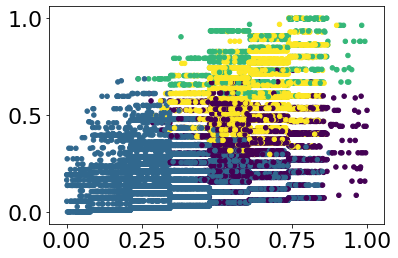

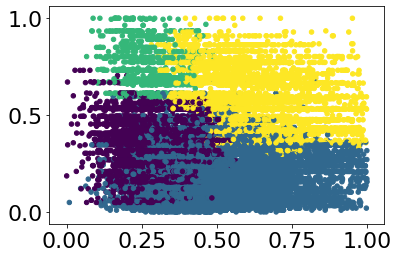

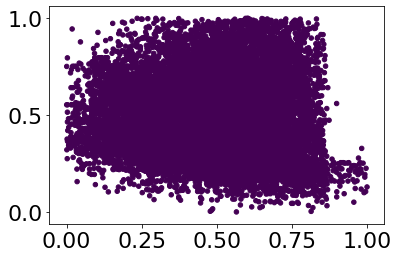

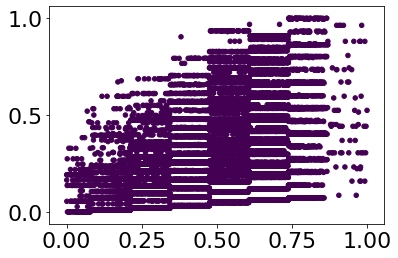

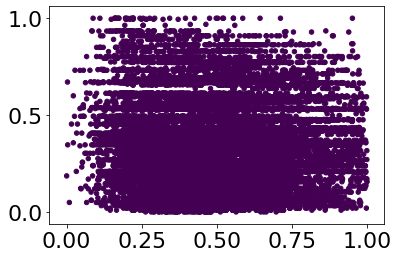

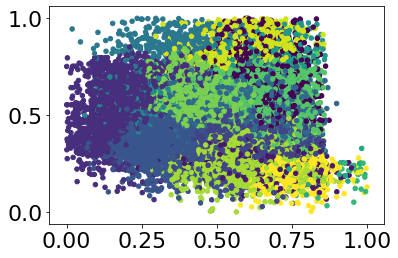

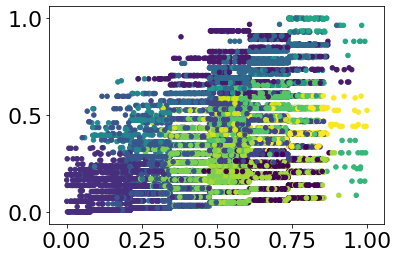

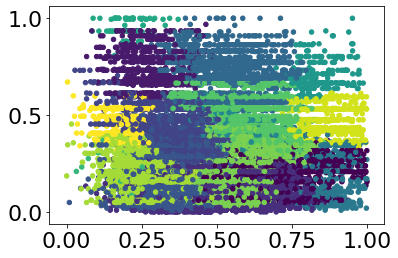

In [55]:
distances = [0.45, 0.55, 0.3]
models = []
for d in distances:
    models.append(AgglomerativeClustering(distance_threshold=d, n_clusters=None, affinity='euclidean', linkage='average'))

for m in models:
    m = m.fit(X)
    scatter_plot_2D(m.labels_, attributes, 'euclidean', 'average', m.distance_threshold)